# Project 01-Benson — Final

Kayleigh Li  
David Luther

## 0. List of Imports

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import googlemaps
import re
import json
import pickle
import copy
import os

from geopy.distance import vincenty
from IPython.display import Image

# sets Google Maps API key to a variable
dl_google_key = os.environ['gmAPI']

%matplotlib inline

In [2]:
# customize settings 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.precision', 3)

## 1. Loading the MTA Subway Turnstile Dataset

In [3]:
def load_it_up(datelist):
    """Takes a list of dates to load data for a range of dates and concatenate 
    it all into one dataframe.
    ---
    IN: List of date strings in yymmdd format corresponding to weeks of available
    turnstile data (list) 
    """

    df = pd.DataFrame()
    base_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'

    for date in datelist:
        csv_url = f"{base_url}{date}.txt"
        print("Loading:", csv_url)
        new_df = pd.read_csv(csv_url)
        df = pd.concat([df, new_df], ignore_index = True)
        
    print("Load complete!")
    
    return df


In [4]:
datelist = ['170506', '170513', '170520', '170527', '170603']
may_df_raw = load_it_up(datelist)

Loading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_170506.txt
Loading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt
Loading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_170520.txt
Loading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_170527.txt
Loading: http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt
Load complete!


## 2. Exploratory Analysis and Preliminary Cleaning of the Data

A look at 10 random rows:

In [7]:
may_df_raw.sample(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
592316,A021,R032,01-00-01,TIMES SQ-42 ST,ACENQRS1237W,BMT,05/26/2017,12:00:00,REGULAR,1879072,2204867
940387,R247,R178,01-00-01,77 ST,6,IRT,05/28/2017,01:00:00,REGULAR,6555281,24623395
51689,N072,R012,05-00-01,34 ST-PENN STA,ACE,IND,04/30/2017,12:00:00,REGULAR,6435745,4741551
338361,R192,R039,00-06-00,MARBLE HILL-225,1,IRT,05/11/2017,00:00:00,REGULAR,5502,30932
924601,R185,R274,00-00-03,191 ST,1,IRT,05/31/2017,12:00:00,REGULAR,1240586,597432
372020,R504,R276,00-00-02,VERNON-JACKSON,7,IRT,05/10/2017,08:00:00,REGULAR,12276467,1411408
899638,PTH10,R547,00-00-01,9TH STREET,1,PTH,05/31/2017,13:21:48,REGULAR,343771,126290
266304,N203,R195,00-03-02,161/YANKEE STAD,BD4,IND,05/12/2017,04:22:00,REGULAR,933033,303466
90940,N422,R318,00-00-01,FULTON ST,G,IND,05/03/2017,16:00:00,REGULAR,4524234,4183953
270087,N300,R113,01-00-03,7 AV,BDE,IND,05/10/2017,21:00:00,REGULAR,1457512,1129660


Some column names have unexpeceted spaces:

In [8]:
may_df_raw.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

...so we strip them.

In [9]:
for col in may_df_raw.columns:
    may_df_raw.rename(columns = {col: col.strip()}, inplace=True)
may_df_raw.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

Values for 'ENTRIES' and 'EXITS are impossibly large — turns out they are cumulative values.

In [10]:
may_df_raw.describe()

,ENTRIES,EXITS
count,9.810e+05,9.810e+05
mean,3.804e+07,3.042e+07
std,2.039e+08,1.830e+08
min,0.000e+00,0.000e+00
25%,5.029e+05,2.491e+05
50%,2.637e+06,1.487e+06
75%,6.770e+06,4.761e+06
max,2.131e+09,2.087e+09


### Determing Unique Station Names

In [11]:
may_df_raw.STATION.value_counts()

34 ST-PENN STA     20581
FULTON ST          20211
23 ST              14816
GRD CNTRL-42 ST    12718
CANAL ST           12283
34 ST-HERALD SQ    11387
CHAMBERS ST        11303
59 ST              11270
86 ST              10938
42 ST-PORT AUTH    10741
TIMES SQ-42 ST     10531
WALL ST            10519
ATL AV-BARCLAY     10178
125 ST              9056
PATH NEW WTC        8999
                   ...  
NEPTUNE AV           630
NORWOOD AV           629
190 ST               629
BRONX PARK EAST      628
CLASSON AV           627
ALLERTON AV          626
BOWERY               624
CORTELYOU RD         624
AVENUE X             623
YORK ST              620
CLEVELAND ST         420
ORCHARD BEACH        419
SUTTER AV            418
BAY RIDGE AV          90
PATH WTC               1
Name: STATION, Length: 376, dtype: int64

The number of unique values in STATION is 376, while according to official record, there should be 472 stations. Thus we know that STATION does not provide unique stations names, though these can be provided (with some argument regarding the bigger stations) by combining STATION and LINENAME. Marked for further investigation (+ explore relationships amongst all the attributes).

In [12]:
may_df_raw["UNIQUE_STATION"] = may_df_raw["STATION"] + ' - ' + may_df_raw["LINENAME"]
may_df_raw["UNIQUE_STATION"].value_counts()

FULTON ST - 2345ACJZ              13274
GRD CNTRL-42 ST - 4567S           12718
34 ST-PENN STA - ACE              11733
34 ST-HERALD SQ - BDFMNQRW        11387
PATH NEW WTC - 1                   8999
42 ST-PORT AUTH - ACENQRS1237W     8852
47-50 STS ROCK - BDFM              7588
METS-WILLETS PT - 7                7432
CANAL ST - JNQRZ6W                 7001
TIMES SQ-42 ST - 1237ACENQRSW      6954
LEXINGTON AV/53 - EM6              6750
59 ST - 456NQRW                    6749
CORTLANDT ST - RNW                 6274
BOWLING GREEN - 45                 6084
JAY ST-METROTEC - ACF              5939
                                  ...  
BRONX PARK EAST - 25                628
18 AV - D                           627
CLASSON AV - G                      627
AVENUE U - N                        627
ALLERTON AV - 25                    626
BOWERY - JZ                         624
CORTELYOU RD - BQ                   624
AVENUE X - F                        623
YORK ST - F                         620


Still, all names are not necessarily unique, as shown by the fact that there are still three instances of 34 ST-Penn Station (below). However, it is in reality two different stations, one serving the ACE along 8th Avenue, and the other serving the 123 along 7th Avenue. For these instances where a large station is separated into two or three, we choose to keep it that way.

In [13]:
may_df_raw[may_df_raw['UNIQUE_STATION'].str.contains('34')].groupby('UNIQUE_STATION').sum()

,ENTRIES,EXITS
UNIQUE_STATION,,
34 ST-HERALD SQ - BDFMNQRW,937487223909,1093914487921
34 ST-HUDSON YD - 7,1331234114,1089680338
34 ST-PENN STA - 123,52487922090,22496284278
34 ST-PENN STA - 123ACE,446062044179,266398736930
34 ST-PENN STA - ACE,99803742171,51482938052
ATL AV-BARCLAY - 2345BDNQR,26542101664,17129507906
ATL AV-BARCLAY - BDNQR2345,180760685009,45066750997
BOROUGH HALL - 2345R,36844009602,16623619252
BOROUGH HALL - R2345,24059623666,1707749819


We rename some stations to remove duplicates (and help Google later).

In [14]:
# this station appeared with a duplicate name, henceforth united
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == '4AV-9 ST - DFGMNR', 'UNIQUE_STATION'] = '4 AV-9 ST - DFGMNR'
# Google thinks this one is in Manhattan, so we clarify to Brooklyn
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'FULTON ST - G', 'UNIQUE_STATION'] = 'FULTON ST (BKLYN) - G'

# these get clarified because the Google Maps API won't recognize them otherwise
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'CONEY IS-STILLW - DFNQ', 'UNIQUE_STATION'] = 'CONEY ISLAND-STILLWELL AV - DFNQ'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'HOWARD BCH JFK - A', 'UNIQUE_STATION'] = 'HOWARD BEACH JFK - A'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == '21 ST-QNSBRIDGE - F', 'UNIQUE_STATION'] = '21 ST-QUEENSBRIDGE - F'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'HOYT-SCHER - ACG', 'UNIQUE_STATION'] = 'HOYT-SCHERMERHORN - ACG'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'COURT SQ - EMG', 'UNIQUE_STATION'] = 'COURT SQUARE - EMG'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'GRD CNTRL-42 ST - 4567S', 'UNIQUE_STATION'] = 'GRAND CENTRAL-42 ST - 4567S'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'AQUEDUCT N.COND - A', 'UNIQUE_STATION'] = 'AQUEDUCT N.CONDUIT - A'
may_df_raw.loc[may_df_raw['UNIQUE_STATION'] == 'FULTON ST - 2345ACJZ', 'UNIQUE_STATION'] = 'FULTON STREET - 2345ACJZ'

# confirm that duplicate station names are now made unique when merged with line name
# for station in sorted(may_df_raw["UNIQUE_STATION"].unique()):
#     print(station)

### Sort for Sequential Turnstile Data

Because we loaded multiple weeks of data in series, the sequence of data for each station and turstile is broken up. Becuase SCP numbers are not unique within the system — or within a station — we have to sort in the following order:
1. unique station
+ remote unit (UNIT)
+ control area (C/A)
+ turnstile (SCP)
+ date
+ time

In [15]:
may_df_sorted = may_df_raw.sort_values(['UNIQUE_STATION', 'UNIT', 'C/A', 'SCP', 'DATE', 'TIME']).reset_index()
may_df_sorted.head(5)

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,UNIQUE_STATION
0,29387,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,00:00:00,REGULAR,12278147,13533772,1 AV - L
1,29388,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,04:00:00,REGULAR,12278188,13534099,1 AV - L
2,29389,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,08:00:00,REGULAR,12278271,13534359,1 AV - L
3,29390,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,12:00:00,REGULAR,12278813,13535235,1 AV - L
4,29391,H007,R248,00-00-00,1 AV,L,BMT,04/29/2017,16:00:00,REGULAR,12279597,13536282,1 AV - L


### What are all the divisions we have present?

In [16]:
may_df_sorted.DIVISION.unique()

array(['BMT', 'IRT', 'IND', 'PTH', 'RIT', 'SRT'], dtype=object)

* BMT, IRT, and IND are the three companies that were absorbed into the MTA
* PTH is the PATH train into NJ
* SRT is perhaps the Staten Island Railway?

### Filter Unneccsary Columns and Reorder Columns

We no longer need STATION and LINE, as those have been merged to provide reasonably unique station identification. An exploration of DESC reveals that it has no significant impact on the actual count of entries/exits, so that goes too.

In [17]:
may_df = may_df_sorted.filter(['UNIQUE_STATION', 'UNIT', 'C/A', 'SCP', 'DIVISION', 'DATE', 'TIME',
       'ENTRIES', 'EXITS'])

# look at 10 random rows
may_df.sample(10, random_state=23)

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS
251882,50 ST - D,R234,E004,00-00-01,BMT,06/02/2017,00:00:00,4919456,5021575
695599,JACKSON AV - 25,R405,R312,00-00-00,IRT,05/13/2017,21:00:00,2586499,247644
279416,59 ST COLUMBUS - ABCD1,R084,N049,01-02-01,IND,05/21/2017,04:00:00,15270179,12471518
110435,207 ST - 1,R037,R188,00-06-01,IRT,05/15/2017,04:00:00,582930,1193840
267719,59 ST - 456NQRW,R050,R244A,01-06-00,IRT,05/24/2017,12:00:00,7470706,9358933
757514,LEXINGTON AV/53 - EM6,R017,N305,01-03-03,IND,05/09/2017,00:00:00,11375346,8629190
651788,GRAND CENTRAL-42 ST - 4567S,R046,R238A,02-00-01,IRT,04/29/2017,12:00:00,1842398,600360
173167,34 ST-PENN STA - 123,R031,R137,02-03-01,IRT,05/17/2017,16:00:00,7142324,4727495
284369,6 AV - FLM123,R163,H003,01-00-01,BMT,05/05/2017,20:00:00,5154006,1330227
597684,FLUSHING-MAIN - 7,R055,R533,00-03-07,IRT,05/20/2017,16:00:00,2047824,1011354


In [18]:
print("Unique Values")
for col in may_df.columns:
    print(f"    *\t{col}:", len(may_df[col].unique()))
# 475 unique subway stations in the MTA system - very close to official record 

Unique Values
    *	UNIQUE_STATION: 475
    *	UNIT: 467
    *	C/A: 734
    *	SCP: 231
    *	DIVISION: 6
    *	DATE: 35
    *	TIME: 32851
    *	ENTRIES: 788004
    *	EXITS: 767013


## 3. Determining Total Entries and Exits per Station

Calculating the difference between one cell in ENTRIES or EXITS and the previous theoretically yields the total number of people through the gate in the time elapsed between readings. With reliable figures, one could simply sum the column to find out how many people walked through the gates over the duration of the entire dataframe.

In [19]:
may_df['ENT DIFF'] = may_df['ENTRIES'].diff()
may_df['EX DIFF'] = may_df['EXITS'].diff()
may_df.head(5)

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
0,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,00:00:00,12278147,13533772,NaN,NaN
1,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,04:00:00,12278188,13534099,41.0,327.0
2,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,08:00:00,12278271,13534359,83.0,260.0
3,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,12:00:00,12278813,13535235,542.0,876.0
4,1 AV - L,R248,H007,00-00-00,BMT,04/29/2017,16:00:00,12279597,13536282,784.0,1047.0


### Negative Numbers and Outliers

Through exploring the differential between current and previous cells in ENTRIES or EXITS, over 10,000 negative values were found. Three major scenarios explain the negative counts:

1. Switch of SCPs or C/As; 
2. Resets of a turnstile 
3. Backward-counting of some turnstiles

When we reach the end of one turnstile's count and continue with another (switch from one SCP or C/A to another), the differnential does not represent an actual count, and must be reset to 0.

Occasionally, a turnstile is reset or replaced. In the first case the differential will be a negative number, and in the second case the differential could be negative or positive. In either case, the differential will almost always be several orders of magnitude larger than the largest feasible entry or exit count, and will *not* represent actual people passing through the gate.

Some turnstiles count backwards, so the differential between current and previous cells in ENTRIES or EXITS will be a negative number in those cases, but the absolute value of this number represents a genuine count.

Another case in which negative numbers appear is that in which several readings from a different turnstile are mislabeled with the current turnstile's SCP number and mixed into the series. This generates alternating negative and positive differentials.

The following makes some corrections and attemps to figure out which numbers might be set as thresholds for negatives and positives for the purpose of filtering out irrelevant data.

### Correcting for Turnstile Transition

To account for the transition from the readings of one turnstile to another, we set ENT_DIFF and EX_DIFF values to 0 whenever a difference in SCP or C/A numbers is found between current row and previous.

In [20]:
may_df.loc[(may_df['SCP'] != may_df['SCP'].shift(+1)) |
           (may_df['C/A'] != may_df['C/A'].shift(+1)),
           ['ENT DIFF', 'EX DIFF']] = 0.0

### Some Examples of Anomalies

Turnstile reset or swap-out.

In [21]:
may_df[656480:656485]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
656480,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/24/2017,09:00:00,856595327,50388744,9.300e+01,1.600e+01
656481,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/24/2017,13:00:00,856595404,50388759,7.700e+01,1.500e+01
656482,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/25/2017,09:00:00,95,21,-8.566e+08,-5.039e+07
656483,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/25/2017,13:00:00,223,40,1.280e+02,1.900e+01
656484,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/25/2017,17:00:00,515,51,2.920e+02,1.100e+01


A backwards-counting turnstile.

In [22]:
may_df[268082:268087]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
268082,59 ST - 456NQRW,R051,R245,00-00-00,IRT,05/14/2017,12:00:00,704335128,721553219,-69.0,44.0
268083,59 ST - 456NQRW,R051,R245,00-00-00,IRT,05/14/2017,16:00:00,704334933,721553274,-195.0,55.0
268084,59 ST - 456NQRW,R051,R245,00-00-00,IRT,05/14/2017,20:00:00,704334546,721553315,-387.0,41.0
268085,59 ST - 456NQRW,R051,R245,00-00-00,IRT,05/15/2017,00:00:00,704334436,721553328,-110.0,13.0
268086,59 ST - 456NQRW,R051,R245,00-00-00,IRT,05/15/2017,04:00:00,704334414,721553330,-22.0,2.0


Data from one turnstile interspersed with another.

In [23]:
may_df[725203:725215]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
725203,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,00:18:12,8544,9195,75.0,321.0
725204,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,04:30:12,8562,9246,18.0,51.0
725205,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,08:42:12,9774,9369,1212.0,123.0
725206,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,12:48:26,557,39,-9217.0,-9330.0
725207,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,16:52:12,11187,10105,10630.0,10066.0
725208,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,20:58:26,1110,263,-10077.0,-9842.0
725209,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,01:02:12,11462,12052,10352.0,11789.0
725210,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,05:08:26,1179,353,-10283.0,-11699.0
725211,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,09:20:26,2152,372,973.0,19.0
725212,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,13:24:12,13704,12443,11552.0,12071.0


### Finding Thresholds for Filtering

In order to inspect the right "neighborhood" of entry and exit differentials to determine the best filter value(s), we tried to determine a realistic maximum number of people that could flow through a single turnstile during the observational period of four hours. One swipe every four seconds seemed to be a realistic estimation, which yields 900 per hour, or 3600 per four hours.

Theoretically, one filter value should be able to be used on the absolute value of the whole series in each ENT_DIFF and EX_DIFF column. However, there are some cases only observed with positive counts that make an argument for setting different threshold values for negative and positive values.

In [24]:
# to tidy things up, if we have time

# def histogram_maker(series, min_val, max_val, xlabel, ylabel, title):
#     pass

#### Histogram of all Exits/Entrances (Abs Value)

This takes the absolute value of all unfiltered entrances and exits and plots them as a histogram.

In [25]:
ents = may_df['ENT DIFF'].abs()
ents_and_exes = ents.append(may_df['EX DIFF'].abs(), ignore_index=True).fillna(0)

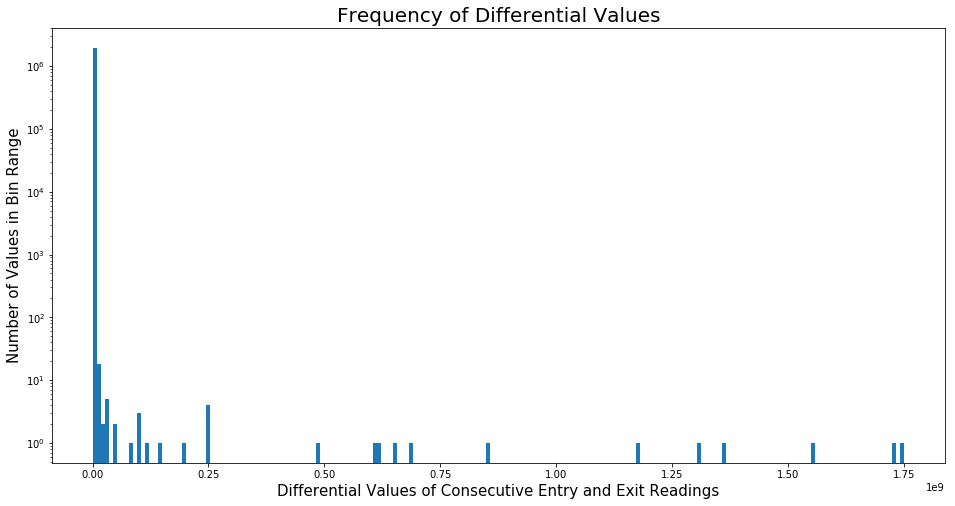

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

ax.hist(ents_and_exes, bins=200)
ax.set_yscale('log')
ax.grid()
plt.xlabel('Differential Values of Consecutive Entry and Exit Readings', fontsize=15)
plt.ylabel('Number of Values in Bin Range', fontsize=15)
plt.title('Frequency of Differential Values', fontsize=20)
plt.grid()

# plt.savefig('../img/differential_hist_grid.png', dpi=200, bbox_inches = 'tight')

#### Negative Differentials

To find a threshold to use for our filter on negative numbers, we look at summary stats and histograms of all negative values in ENT_DIFF and EX_DIFF columns. Setting different numbers for min_val and max_val allow for a targeted inspection of a specific range of values.

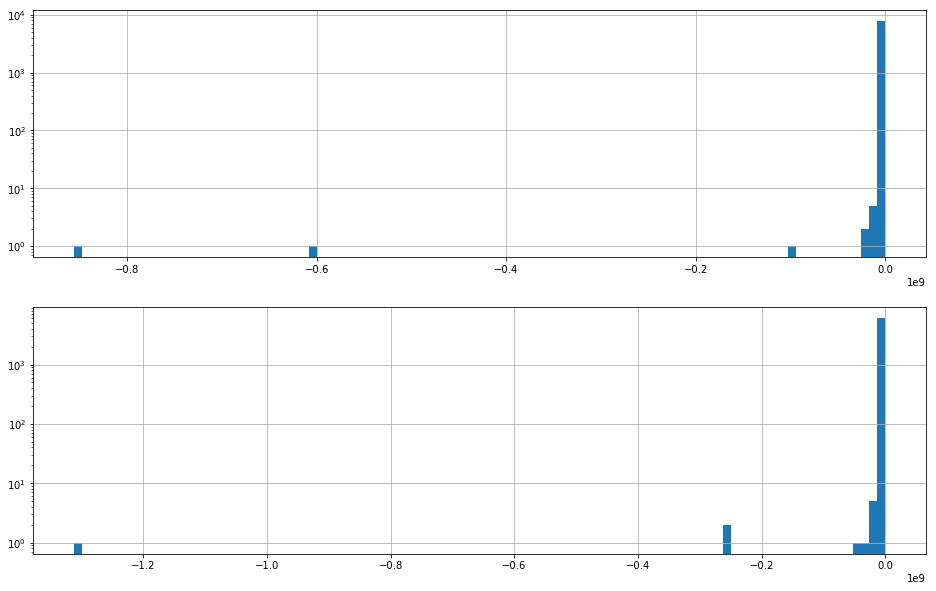

In [27]:
# specify range to inspect
min_val = -10e10
max_val = 0

ent_neg_slice = may_df[(may_df['ENT DIFF'] > min_val) & (may_df['ENT DIFF'] < max_val)]['ENT DIFF']
ex_neg_slice = may_df[(may_df['EX DIFF'] > min_val) & (may_df['EX DIFF'] < max_val)]['EX DIFF']

fig, ax = plt.subplots(2, 1, figsize=(16,10))

plots_to_make = [ent_neg_slice, ex_neg_slice]

for series, ax_obj in zip(plots_to_make, ax):
    ax_obj.hist(series, bins=100)
    ax_obj.set_yscale('log')
    # if x is log, need to take absolute value series
    # ax_obj.set_xscale('log')
    ax_obj.grid()

In [28]:
entries_neg = may_df[may_df['ENT DIFF'] < 0]['ENT DIFF']
exits_neg = may_df[may_df['EX DIFF'] < 0]['EX DIFF']

In [29]:
print("ENTRIES (NEG):")
print(entries_neg.describe())
print("Median:", entries_neg.median(), "\n")
print("EXITS (NEG):")
print(exits_neg.describe())
print("Median:", exits_neg.median())

ENTRIES (NEG):
count    7.668e+03
mean    -2.268e+05
std      1.205e+07
min     -8.566e+08
25%     -5.560e+02
50%     -2.480e+02
75%     -6.700e+01
max     -1.000e+00
Name: ENT DIFF, dtype: float64
Median: -248.0 

EXITS (NEG):
count    6.110e+03
mean    -3.362e+05
std      1.742e+07
min     -1.313e+09
25%     -3.570e+02
50%     -1.310e+02
75%     -3.400e+01
max     -1.000e+00
Name: EX DIFF, dtype: float64
Median: -131.0


This allows inspection of actual values along with their indices so we can find and inspect to see what's going on around them.

In [30]:
(entries_neg
# .sample(20)
 .sort_values()
# .head(10)
)[0:20]

656482   -8.566e+08
363769   -6.058e+08
875219   -1.008e+08
653426   -2.024e+07
366670   -1.940e+07
401002   -1.680e+07
399529   -1.601e+07
227363   -1.343e+07
913550   -1.182e+07
344866   -1.051e+07
548310   -7.897e+06
108823   -7.586e+06
344335   -5.962e+06
211584   -5.439e+06
515978   -4.607e+06
738155   -4.470e+06
508070   -2.606e+06
362652   -2.526e+06
87883    -2.341e+06
146073   -2.137e+06
Name: ENT DIFF, dtype: float64

Upon inspecting values near the 3600/hour threshold, we found out that nearly all values between -3000 > n > 0 can be attributed to a reverse-counting turnstile, and values n < -3000 can be attrubuted to a reset or another anomaly.

#### Positive Differentials

Again, we look at histograms and summary stats of positive entrance and exit differentials to hone in on a filter threshold.

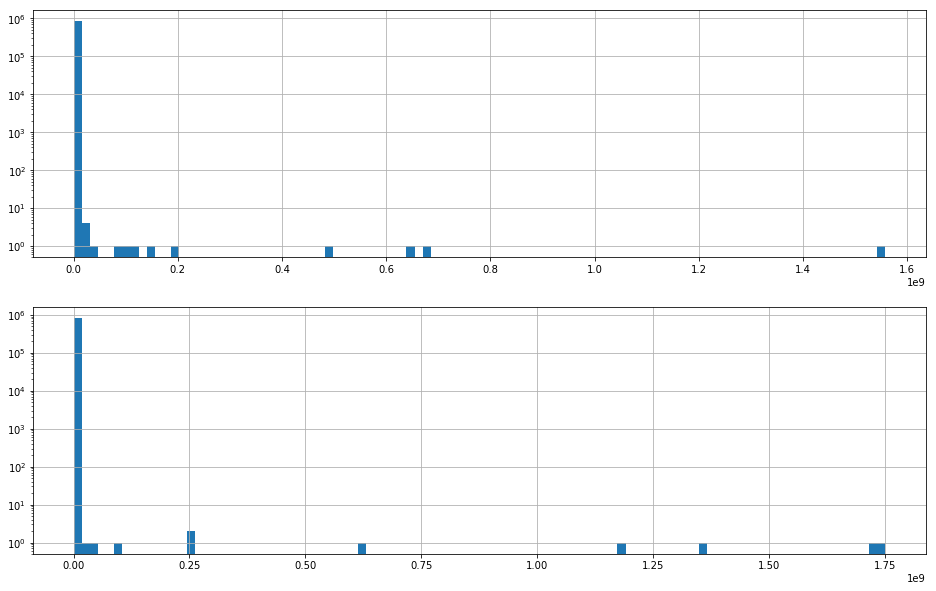

In [31]:
# specify range to inspect
min_val = 0
max_val = 10e10

ent_pos_slice = may_df[(may_df['ENT DIFF'] > min_val) & (may_df['ENT DIFF'] < max_val)]['ENT DIFF']
ex_pos_slice = may_df[(may_df['EX DIFF'] > min_val) & (may_df['EX DIFF'] < max_val)]['EX DIFF']

plots_to_make = [ent_pos_slice, ex_pos_slice]

fig, ax = plt.subplots(2, 1, figsize=(16,10))

for series, ax_obj in zip(plots_to_make, ax):
    ax_obj.hist(series, bins=100)
    ax_obj.set_yscale('log')
    # ax_obj.set_xscale('log')
    ax_obj.grid()

In [32]:
entries_pos = may_df[may_df['ENT DIFF'] > 0]['ENT DIFF']
exits_pos = may_df[may_df['EX DIFF'] > 0]['EX DIFF']

In [33]:
print("ENTRIES (POS):")
print(entries_pos.describe())
print("Median:", entries_pos.median(), "\n")
print("EXITS (POS):")
print(exits_pos.describe())
print("Median:", exits_pos.median())

ENTRIES (POS):
count    8.216e+05
mean     5.294e+03
std      2.109e+06
min      1.000e+00
25%      3.200e+01
50%      1.200e+02
75%      2.990e+02
max      1.558e+09
Name: ENT DIFF, dtype: float64
Median: 120.0 

EXITS (POS):
count    8.266e+05
mean     9.030e+03
std      3.444e+06
min      1.000e+00
25%      2.300e+01
50%      7.800e+01
75%      2.040e+02
max      1.751e+09
Name: EX DIFF, dtype: float64
Median: 78.0


In [34]:
(entries_pos
# .sample(20)
 .sort_values(ascending=False)
 .head(10)
)

574146    1.558e+09
312004    6.832e+08
652164    6.528e+08
655513    4.885e+08
428619    1.979e+08
227874    1.476e+08
295648    1.170e+08
443550    9.825e+07
12100     8.356e+07
650838    3.420e+07
Name: ENT DIFF, dtype: float64

In [35]:
(entries_pos[(entries_pos > 3600) & (entries_pos < 8000)]
 .sort_values(ascending=False)
 .head(20))

970481    7149.0
360600    6056.0
720925    5506.0
723024    5056.0
650199    5039.0
721975    4880.0
655422    4517.0
650102    4481.0
721765    4351.0
650138    4310.0
775803    4300.0
970288    4229.0
722185    4194.0
650176    4193.0
650182    4173.0
650096    4051.0
650188    4051.0
202172    4044.0
723234    4040.0
650223    4021.0
Name: ENT DIFF, dtype: float64

Completely legitimate count of 4310 in a four hour period at Grand Central Station — one of the few places where this might be believable.

In [36]:
may_df[650136:650141]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
650136,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/16/2017,12:00:00,28678113,8769273,690.0,1399.0
650137,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/16/2017,16:00:00,28679413,8769931,1300.0,658.0
650138,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/16/2017,20:00:00,28683723,8769962,4310.0,31.0
650139,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/17/2017,00:00:00,28685154,8770154,1431.0,192.0
650140,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/17/2017,04:00:00,28685347,8770192,193.0,38.0


A couple cases where turnstiles went offline from between one cycle to several days. During this period they kept on counting, then dumped all counts for the offline period when online again.

In [37]:
may_df[650197:650202]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
650197,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/26/2017,08:00:00,28752937,8790565,735.0,151.0
650198,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/26/2017,12:00:00,28754310,8791265,1373.0,700.0
650199,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/26/2017,20:00:00,28759349,8791915,5039.0,650.0
650200,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/27/2017,00:00:00,28761045,8792255,1696.0,340.0
650201,GRAND CENTRAL-42 ST - 4567S,R046,R238,00-03-02,IRT,05/27/2017,04:00:00,28761452,8792362,407.0,107.0


In [38]:
may_df[970479:970484]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF
970479,WILSON AV - L,R295,H032,00-00-02,BMT,05/10/2017,00:00:00,6388543,5392570,130.0,337.0
970480,WILSON AV - L,R295,H032,00-00-02,BMT,05/10/2017,04:00:00,6388571,5392656,28.0,86.0
970481,WILSON AV - L,R295,H032,00-00-02,BMT,05/13/2017,00:00:00,6395720,5396288,7149.0,3632.0
970482,WILSON AV - L,R295,H032,00-00-02,BMT,05/13/2017,04:00:00,6395780,5396430,60.0,142.0
970483,WILSON AV - L,R295,H032,00-00-02,BMT,05/13/2017,08:00:00,6395939,5396461,159.0,31.0


Unlike the negative numbers, there are a number of counts in the 4000s that appear to be legitimate. As these are quite significant values, we would rather not filter them out of our count. Several values between 5000 and 8000 seem to represent situations in which one turnstile goes offline for several days but keeps on counting, then returns a value representing this whole offline period. This would be problematic if we were looking at daily or hourly counts, but not for a view of the entire month.

### And We Have Thresholds

Inspections of cases revealed that any negative value between -3000 and 0 in the differentials column represents a trusted reading, as does any positive value between 0 and 8000. We honed in on this range by figuring that the max number of people through a turnstile would be one every four seconds, or 15 per minute, which comes out to 900 per hour. Since readings on turnstiles were taken every four hours, we would expect values up to 3600 to be legitimate. A small number of special cases revealed turnstiles that went offline for several days but kept on counting. When they came back online, they dumped the count for the last three days, which ended up being between 4000 and 8000. Because we are looking at the total traffic over the duration of the data, these are valid counts.

### Filtering Anomalies

If the value in either ENT_DIFF or EX_DIFF falls outside of the range, we set both values to 0.



In [39]:
may_df.loc[
    (may_df['ENT DIFF'] < -3000) | (may_df['EX DIFF'] < -3000),
    ['ENT DIFF', 'EX DIFF']] = 0.0
 
may_df.loc[
    (may_df['ENT DIFF'] > 8000) | (may_df['EX DIFF'] > 8000),
    ['ENT DIFF', 'EX DIFF']] = 0.0

We take the absolute value of all diffential and create two new columns for them.

In [40]:
may_df['ENTRY DIFFS (ABS)'] = may_df['ENT DIFF'].abs()
may_df['EXIT DIFFS (ABS)'] = may_df['EX DIFF'].abs()

This following cell sets the threshold of the abs of ENT DIFFS and EX DIFFS at 3600, instead of -3000 to 8000. To run, uncomment the code and comment the entire box right under "Filtering Anomalies," then run from the top.

**Not surprisingly, the final rankings of the busiest stations are no different using this pure estimation approach.** Whatever advantage is lost due to slightly less accurate counts is more than gained in its expedience. Note to self for the next time.

In [41]:
# may_df.loc[
#     (may_df['ENTRY DIFFS (ABS)'] > 3600) | (may_df['EXIT DIFFS (ABS)'] > 3600),
#     ['ENTRY DIFFS (ABS)', 'EXIT DIFFS (ABS)']] = 0.0

Confirmed:

In [43]:
may_df[656480:656485].filter(['UNIQUE_STATION', 
                              'UNIT', 
                              'C/A', 
                              'SCP', 
                              'DIVISION', 
                              'DATE', 
                              'TIME', 
                              'ENTRIES', 
                              'EXITS', 
                              'ENTRY DIFFS (ABS)', 
                              'EXIT DIFFS (ABS)'
                             ])

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENTRY DIFFS (ABS),EXIT DIFFS (ABS)
656480,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/24/2017,09:00:00,856595327,50388744,93.0,16.0
656481,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/24/2017,13:00:00,856595404,50388759,77.0,15.0
656482,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/25/2017,09:00:00,95,21,0.0,0.0
656483,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/25/2017,13:00:00,223,40,128.0,19.0
656484,GRAND CENTRAL-42 ST - 4567S,R048,R241A,00-00-04,IRT,05/25/2017,17:00:00,515,51,292.0,11.0


In [100]:
may_df[725203:725215]

,UNIQUE_STATION,UNIT,C/A,SCP,DIVISION,DATE,TIME,ENTRIES,EXITS,ENT DIFF,EX DIFF,ENTRY DIFFS (ABS),EXIT DIFFS (ABS)
725203,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,00:18:12,8544,9195,75.0,321.0,75.0,321.0
725204,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,04:30:12,8562,9246,18.0,51.0,18.0,51.0
725205,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,08:42:12,9774,9369,1212.0,123.0,1212.0,123.0
725206,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,12:48:26,557,39,0.0,0.0,0.0,0.0
725207,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,16:52:12,11187,10105,0.0,0.0,0.0,0.0
725208,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/30/2017,20:58:26,1110,263,0.0,0.0,0.0,0.0
725209,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,01:02:12,11462,12052,0.0,0.0,0.0,0.0
725210,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,05:08:26,1179,353,0.0,0.0,0.0,0.0
725211,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,09:20:26,2152,372,973.0,19.0,973.0,19.0
725212,JOURNAL SQUARE - 1,R552,PTH03,00-00-09,PTH,05/31/2017,13:24:12,13704,12443,0.0,0.0,0.0,0.0


## 4. Calculating the Busiest Stations

...is as easy as adding the absolute value of the entry and exit differentials together, then sorting on that value.

In [44]:
may_df['TOTAL TRAFFIC'] = may_df['ENTRY DIFFS (ABS)'] + may_df['EXIT DIFFS (ABS)']

In [54]:
may_traffic_df = (may_df
 .groupby('UNIQUE_STATION')['TOTAL TRAFFIC', 'ENTRY DIFFS (ABS)', 'EXIT DIFFS (ABS)']
 .sum()
# .sort_values(by='ENTRY DIFFS (ABS)', ascending=False)
# .head(10)
)

In [56]:
may_traffic_df.sort_values(by='TOTAL TRAFFIC', ascending=False).head(10)

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS)
UNIQUE_STATION,,,
GRAND CENTRAL-42 ST - 4567S,8.240e+06,4.317e+06,3.923e+06
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06
42 ST-PORT AUTH - ACENQRS1237W,4.732e+06,2.750e+06,1.982e+06
34 ST-PENN STA - ACE,4.496e+06,2.386e+06,2.110e+06
14 ST-UNION SQ - LNQR456W,4.277e+06,2.284e+06,1.993e+06
TIMES SQ-42 ST - 1237ACENQRSW,4.050e+06,2.066e+06,1.984e+06
47-50 STS ROCK - BDFM,3.365e+06,1.672e+06,1.693e+06
FULTON STREET - 2345ACJZ,3.342e+06,1.739e+06,1.602e+06
FLUSHING-MAIN - 7,3.329e+06,1.879e+06,1.450e+06


In [57]:
top_30_stations = may_traffic_df.sort_values(by='TOTAL TRAFFIC', ascending=False).head(30)
top_30_stations

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS)
UNIQUE_STATION,,,
GRAND CENTRAL-42 ST - 4567S,8.240e+06,4.317e+06,3.923e+06
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06
42 ST-PORT AUTH - ACENQRS1237W,4.732e+06,2.750e+06,1.982e+06
34 ST-PENN STA - ACE,4.496e+06,2.386e+06,2.110e+06
14 ST-UNION SQ - LNQR456W,4.277e+06,2.284e+06,1.993e+06
TIMES SQ-42 ST - 1237ACENQRSW,4.050e+06,2.066e+06,1.984e+06
47-50 STS ROCK - BDFM,3.365e+06,1.672e+06,1.693e+06
FULTON STREET - 2345ACJZ,3.342e+06,1.739e+06,1.602e+06
FLUSHING-MAIN - 7,3.329e+06,1.879e+06,1.450e+06


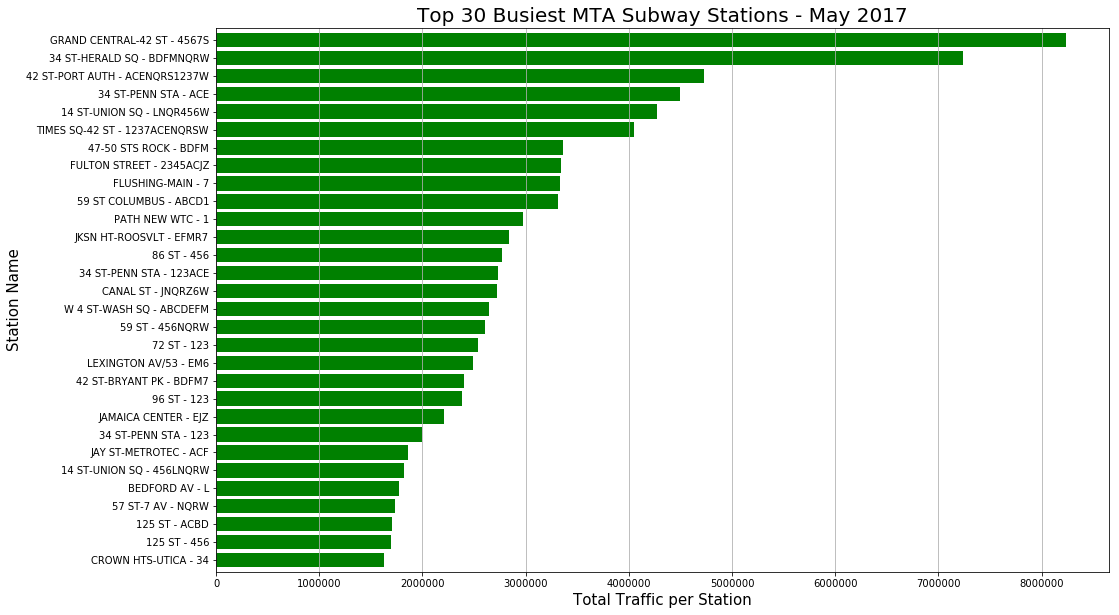

In [96]:
(top_30_stations['TOTAL TRAFFIC']
 .plot(kind='barh',
       color = 'green', 
       linewidth=10,
       width=0.8,
       align='center',
       figsize =(16,10)
      )
) 

# alpha=0.5,color='y',rwidth=0.8)
plt.xlabel('Total Traffic per Station', fontsize=15)
plt.ylabel('Station Name', fontsize=15)
plt.title('Top 30 Busiest MTA Subway Stations - May 2017', fontsize=20)
plt.grid(True, axis='x')
plt.gca().invert_yaxis()

# plt.savefig('../img/top30.png', dpi=200, bbox_inches = 'tight')

## 5. Location, Location, Location: Enter the Goog

Because we intend to compare station locations to locations of tech companies and universities, we need to grab the latitude and longitude of our stations, companies, and universities to compute that distance. We'll use the Google Maps API to query lat/lng for each one.

In [105]:
def find_location(search_array, search_type, gkey, lcn_dict=None):
    """
    This test function will take in an array of searchable venues, look them up on the Google API, and return their
    location as latitude and longitude.
    
    Type key:
    0. Subway Station
    1. Company
    2. College
    
    ---
    
    IN: ndarray, list, etc. of locations; type (int); Google API key (str)
        * specify dictionary for lcn_dict parameter if you'd like to add to it
    OUT: dictionary of venues as keys and latitude/longitude as items; venues for which no data was found
    """
    
    gmaps = googlemaps.Client(key=gkey)
    no_value = []
    search_types = ['subway station', 'company headquarters', 'college']
    if lcn_dict == None:
        lcn_dict = {}

    for venue in search_array:
        print(f"Searching for: {venue}                              \r", end='')
        search_me = venue + search_types[search_type] + ' NEW YORK'
        result = gmaps.geocode(search_me)
        if result:
            latitude = result[0]['geometry']['location']['lat']
            longitude = result[0]['geometry']['location']['lng']
        else:
            latitude = np.nan
            longitude = np.nan
            print(f"*** {venue}: No value found!")
            no_value.append(venue)
        lcn_dict[venue] = (latitude, longitude)
        
    print("Complete!                                                   ")
        
    return lcn_dict, no_value

In [106]:
# comment code to load from JSON file later

# station_names = may_df['UNIQUE_STATION'].unique() # numpy array of unique names

# station_lcns, stations_nolcndata = find_location(station_names, 0, dl_google_key)

In [107]:
# for station in stations_nolcndata:
#    print(station) 

In [108]:
# cycles through stations with no location data and offers opportunity to rename
# both in list and df

# this is tricky because it increases the chance of mismatch between dataframes and location dictionaries
# which is why much of the renaming has been done at the beginning of the cleaning section

# for index, station in enumerate(stations_nolcndata[:]):
#     print(f"Enter new name for {station} (or hit enter to leave as-is)")
#     newname = input("> ").strip()
#     if newname != '':
#         may_df.loc[may_df['UNIQUE_STATION'] == station, 'UNIQUE_STATION'] = newname
#         stations_nolcndata[index] = newname
#         del station_lcns[station]

# for station in stations_nolcndata:
#     print(station)

In [109]:
# try one more time with stations that didn't return lat/lng info
# station_lcns_updated, stations_nolcndata = find_location(stations_nolcndata, 0, dl_google_key, lcn_dict=station_lcns)

In [110]:
# station_lcns = station_lcns_updated

Google routinely returns some incorrect values for relevant stations — e.g. it returns the same lat/lng for every 23rd St station, which is the correct value for the 23rd St - NRW. Regretfully, we opt for the manual approach to correct these. (Source: http://web.mta.info/developers/data/nyct/subway/Stations.csv)

In [111]:
# station_lcns['23 ST - 1'] = [40.884667, -73.900870]
# station_lcns['23 ST - 6'] = [40.739864, -73.986599]
# station_lcns['23 ST - CE'] = [40.745906, -73.998041]
# station_lcns['23 ST - FM'] = [40.742878, -73.992821]
# station_lcns['TWENTY THIRD ST - 1'] = [40.742878, -73.992821]
# len(station_lcns)

In [112]:
# 50 notable tech companies in NYC
companies = ['Amazon','AOL','Apple','AppNexus','Bloomberg','Blue Apron 40 w 23rd St','BuzzFeed','ETrade','Etsy','Facebook',
                 'Fresh Direct','Google','Information Builders','LinkedIn','MediaRadar','Microsoft','Oscar',
                 'Salesforce','Shutterstock','Spotify','Tumblr','Twitter','VICE Media','WeWork','Yelp','Yext',
                 'Zocdoc','Betterment','Bonobos','Compass','Grubhub','Fareportal','FanDuel','MediaMath',
                 'Integral Ad Science','MondoDB','Sprinklr','Uber','Vimeo','Intersection','Snapchat','Flatiron Health',
                 'Gilt','LearnVest','OnDeck','Squarespace','Thrillist','Warby Parker','TMP Worldwide','Refinery29']

# company_lcns, companies_nolcndata = find_location(companies, 1, dl_google_key)

In [113]:
# 10 notable universities in NYC
colleges = ['City University of New York Harlem','Yeshiva University', 'Columbia University',
            'New York Institute of Technology','New York University','Pace University', 'Fordham University',
            'The New School','Hunter College','Baruch College'] 

# company_and_college_lcns, colleges_nolcndata = find_location(colleges, 2, dl_google_key, lcn_dict=company_lcns)

In [114]:
# throw these into JSON files for later

# with open('../json/station_lcns.txt', 'w') as fs:
#     json.dump(station_lcns, fs)

# with open('../json/candc_lcns.txt', 'w') as fc:
#     json.dump(company_and_college_lcns, fc)

In [58]:
# and then read them
with open('../json/station_lcns.txt', 'r') as fs:
    station_lcns_load = json.load(fs)
    
with open('../json/candc_lcns.txt', 'r') as fc:
    company_and_college_lcns_load = json.load(fc)

A quick check to make sure the counts are correct (stations should be 475, companies/colleges should be 60).

In [60]:
print(len(station_lcns_load))
print(len(company_and_college_lcns_load))

475
60


**FYI, latitude and longitude of NYC:** 
* Latitude = 40.7141667 
* Longitude = -74.0063889

## 6. Intermission (and Pickling)

As we've changed some names along the way and taken the time to pull a bunch of location data down from Google, we'll save the DF so we can pick back up here at any time while working on the rest.

In [117]:
# with open('../pickles/may_traffic_pre_merge.pkl', 'wb') as picklefile:
#     pickle.dump(may_traffic_df, picklefile)

In [118]:
# with open('../pickles/may_traffic_pre_merge.pkl', 'rb') as picklefile: 
#     may_traffic_df = pickle.load(picklefile)

## 7. Merging Station Location with Traffic

### Turning Location Dicts into DFs

I'm not sure why we didn't make these things into DFs or Series in the function, but now we take dictionaries of lat/lng and merge with the traffic info df using the station names as indices.

In [61]:
# if these don't load from JSON you'll need to change variables
station_locations = pd.DataFrame.from_dict(station_lcns_load, orient='index')
station_locations.columns = ['Latitude', 'Longitude']
company_college_locations = pd.DataFrame.from_dict(company_and_college_lcns_load, orient='index')
company_college_locations.columns = ['Latitude', 'Longitude']

In [62]:
station_locations = station_locations.reindex(station_locations.index.rename('UNIQUE_STATION'))
station_locations.head(10)

,Latitude,Longitude
UNIQUE_STATION,,
1 AV - L,40.763,-73.968
103 ST - 1,40.750,-73.863
103 ST - 6,40.790,-73.948
103 ST - BC,40.750,-73.863
103 ST-CORONA - 7,40.750,-73.863
104 ST - A,40.695,-73.844
104 ST - JZ,40.695,-73.844
110 ST - 6,40.804,-73.966
111 ST - 7,40.752,-73.855


In [63]:
company_college_locations.head(10)

,Latitude,Longitude
Amazon,40.749,-73.985
AOL,40.731,-73.992
Apple,40.882,-73.989
AppNexus,40.742,-73.991
Bloomberg,40.762,-73.968
Blue Apron 40 w 23rd St,40.742,-73.991
BuzzFeed,40.742,-74.000
ETrade,40.763,-73.979
Etsy,40.701,-73.988
Facebook,40.731,-73.992


### Joining Station Traffic and Location

In [64]:
may_traffic_df = may_traffic_df.join(station_locations)

In [65]:
may_traffic_df.sort_values(by='TOTAL TRAFFIC', ascending=False).head(10)

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS),Latitude,Longitude
UNIQUE_STATION,,,,,
GRAND CENTRAL-42 ST - 4567S,8.240e+06,4.317e+06,3.923e+06,40.753,-73.977
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06,40.750,-73.988
42 ST-PORT AUTH - ACENQRS1237W,4.732e+06,2.750e+06,1.982e+06,40.757,-73.990
34 ST-PENN STA - ACE,4.496e+06,2.386e+06,2.110e+06,40.751,-73.990
14 ST-UNION SQ - LNQR456W,4.277e+06,2.284e+06,1.993e+06,40.735,-73.991
TIMES SQ-42 ST - 1237ACENQRSW,4.050e+06,2.066e+06,1.984e+06,40.755,-73.987
47-50 STS ROCK - BDFM,3.365e+06,1.672e+06,1.693e+06,40.758,-73.982
FULTON STREET - 2345ACJZ,3.342e+06,1.739e+06,1.602e+06,40.709,-74.008
FLUSHING-MAIN - 7,3.329e+06,1.879e+06,1.450e+06,40.760,-73.830


## 8. Calculating Weight of Proximity of Station to Companies/Colleges

### Building Necessary Formulas

Busy stations don't matter if their patrons wouldn't be interested in the event in question. The following illustrate two examples of how one might weight a station-company relationship based on distance. We have elected to use the former, given its simplicity and the fact that assumption plays heavily here, instead of concrete data concerning the likelihood of employees to use one station or another.

In [66]:
# a couple different ways of weighting a station based on proximity to companies/colleges

def find_weight1(dist):
    """Returns a number from 0-1 based on distance between station and company/college,
    favoring closer distances and discounting anything farther than 1 mile away.
    ---
    IN: Distance in miles (int or float)
    OUT: Weight between 0 and 1 (int or float)
    """
    if 0 < dist <= 0.25:
        weight = 1
    elif 0.25 < dist <= 0.5:
        weight = 0.75
    elif 0.5 < dist <= 0.75:
        weight = 0.5
    elif 0.75 < dist <= 1:
        weight = 0.25
    else:
        weight = 0
    
    return weight

def find_weight2(dist):
    """Returns a number from 0-1 based on a curve we thought might represent the 
    likelihood that someone at a particular company/college would use the 
    corresponding station. It is completely subjective and has no correlation with
    any collected or observed data whatsoever, so justifying its use would be 
    difficult. Still, we were curious to see how it might work, so we coded it up
    as an option.
    ---
    IN: Distance in miles (int or float)
    OUT: Weight between 0 and 1 (float)

    """
    
    return 1 - (1 - 1/50**dist)**4

In [67]:
def calculate_distance(lat1, lng1, lat2, lng2):
    """Takes the latitude and longitude of two points, calculates distance, and returns 
    it in miles.
    ---
    IN: Two pairs of lat/lng (int or float)
    OUT: Distance between in miles (float)
    """
    
    ll_1 = (lat1, lng1)
    ll_2 = (lat2, lng2)
    
    return vincenty(ll_1,ll_2).miles

In [68]:
def station_weight(s_lat, s_lng):
    """To be applied to the stations DF to find cumulative weighting for each
    station based on proximity to companies/colleges of interest.
    ---
    IN: DF row (series obj)
    OUT: Cumulative weight (float)"""
    
    # is there a better way to catch a nan?
    if not s_lat > 0:
        return np.nan
    
    weight_list = []
    
    for row in company_college_locations.iterrows():
        c_lat = row[1][0]
        c_lng = row[1][1]
        dist = calculate_distance(s_lat, s_lng, c_lat, c_lng)

        # change formula name to use 
        weight = find_weight1(dist)
        weight_list.append(weight)

    cumulative_weight = np.sum(weight_list)
    
    return cumulative_weight

### Generating Weights for Each Station

In [69]:
may_traffic_df['Weight'] = may_traffic_df.apply(lambda row: station_weight(row['Latitude'], row['Longitude']), axis=1)

In [70]:
may_traffic_df.sort_values(by="Weight", ascending=False).head(10)

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS),Latitude,Longitude,Weight
UNIQUE_STATION,,,,,,
23 ST - NRW,1.185e+06,7.691e+05,4.156e+05,40.742,-73.989,19.25
23 ST - FM,1.559e+06,8.595e+05,6.992e+05,40.743,-73.993,19.00
TWENTY THIRD ST - 1,5.821e+05,2.651e+05,3.170e+05,40.743,-73.993,19.00
28 ST - 6,1.321e+06,6.696e+05,6.519e+05,40.745,-73.989,18.75
33 ST - 6,1.540e+06,8.738e+05,6.658e+05,40.749,-73.989,18.75
23 ST - 6,1.503e+06,8.243e+05,6.787e+05,40.740,-73.987,18.25
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06,40.750,-73.988,17.75
28 ST - 1,6.667e+05,4.081e+05,2.586e+05,40.747,-73.993,17.50
28 ST - NRW,8.338e+05,4.035e+05,4.303e+05,40.747,-73.993,17.50


### Calculate "Relevance" of Each Station

In order to find out which stations should be priorities for flyer distribution, we multiply the calculated weight by the total traffic of the station, and then divide by 10,000,000 to scale it to a readable number.

In [71]:
may_traffic_df['Relevance'] = (may_traffic_df['TOTAL TRAFFIC'] * may_traffic_df['Weight']) / 1e7

In [72]:
may_traffic_df.sort_values(by="Relevance", ascending=False).head(20)

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS),Latitude,Longitude,Weight,Relevance
UNIQUE_STATION,,,,,,,
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06,40.750,-73.988,17.75,12.844
GRAND CENTRAL-42 ST - 4567S,8.240e+06,4.317e+06,3.923e+06,40.753,-73.977,11.00,9.064
34 ST-PENN STA - ACE,4.496e+06,2.386e+06,2.110e+06,40.751,-73.990,16.25,7.307
14 ST-UNION SQ - LNQR456W,4.277e+06,2.284e+06,1.993e+06,40.735,-73.991,16.00,6.843
TIMES SQ-42 ST - 1237ACENQRSW,4.050e+06,2.066e+06,1.984e+06,40.755,-73.987,14.25,5.771
42 ST-PORT AUTH - ACENQRS1237W,4.732e+06,2.750e+06,1.982e+06,40.757,-73.990,10.50,4.968
34 ST-PENN STA - 123ACE,2.728e+06,1.628e+06,1.101e+06,40.751,-73.990,16.25,4.434
47-50 STS ROCK - BDFM,3.365e+06,1.672e+06,1.693e+06,40.758,-73.982,10.75,3.617
42 ST-BRYANT PK - BDFM7,2.405e+06,1.242e+06,1.164e+06,40.755,-73.984,13.75,3.307


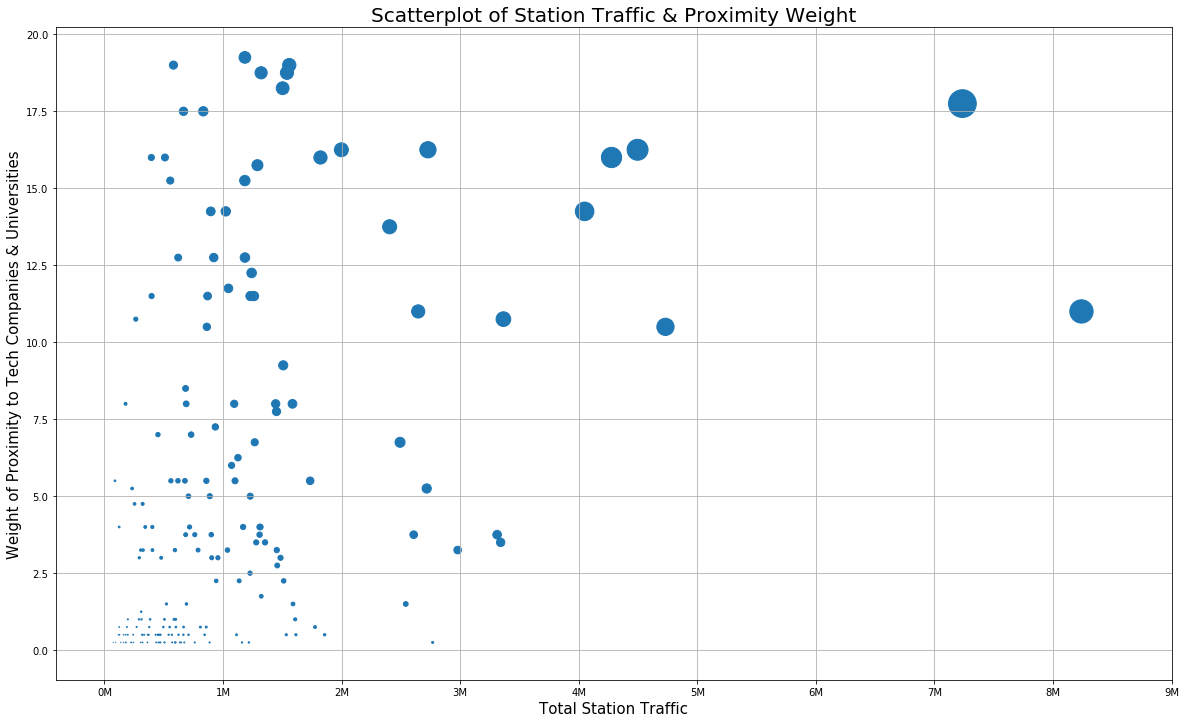

In [102]:
dist1 = may_traffic_df['TOTAL TRAFFIC']
dist2 = may_traffic_df.Weight
s = may_traffic_df['Relevance']*60
plt.figure(figsize=(20,12))
plt.scatter(dist1, dist2, s=s)  
# plt.xscale('log')
plt.grid(True, which='both')
plt.xticks([i*1e6 for i in range(10)], [str(i)+'M' for i in range(10)])
plt.xlabel('Total Station Traffic', fontsize = 15)
plt.ylabel('Weight of Proximity to Tech Companies & Universities',fontsize = 15)
plt.title('Scatterplot of Station Traffic & Proximity Weight',fontsize = 20);

# plt.savefig('../img/scatter1.png', dpi=200, bbox_inches='tight')

In [89]:
top_30_important_stations = may_traffic_df.sort_values(by="Relevance", ascending=False).head(30)
top_30_important_stations

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS),Latitude,Longitude,Weight,Relevance
UNIQUE_STATION,,,,,,,
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06,40.750,-73.988,17.75,12.844
GRAND CENTRAL-42 ST - 4567S,8.240e+06,4.317e+06,3.923e+06,40.753,-73.977,11.00,9.064
34 ST-PENN STA - ACE,4.496e+06,2.386e+06,2.110e+06,40.751,-73.990,16.25,7.307
14 ST-UNION SQ - LNQR456W,4.277e+06,2.284e+06,1.993e+06,40.735,-73.991,16.00,6.843
TIMES SQ-42 ST - 1237ACENQRSW,4.050e+06,2.066e+06,1.984e+06,40.755,-73.987,14.25,5.771
42 ST-PORT AUTH - ACENQRS1237W,4.732e+06,2.750e+06,1.982e+06,40.757,-73.990,10.50,4.968
34 ST-PENN STA - 123ACE,2.728e+06,1.628e+06,1.101e+06,40.751,-73.990,16.25,4.434
47-50 STS ROCK - BDFM,3.365e+06,1.672e+06,1.693e+06,40.758,-73.982,10.75,3.617
42 ST-BRYANT PK - BDFM7,2.405e+06,1.242e+06,1.164e+06,40.755,-73.984,13.75,3.307


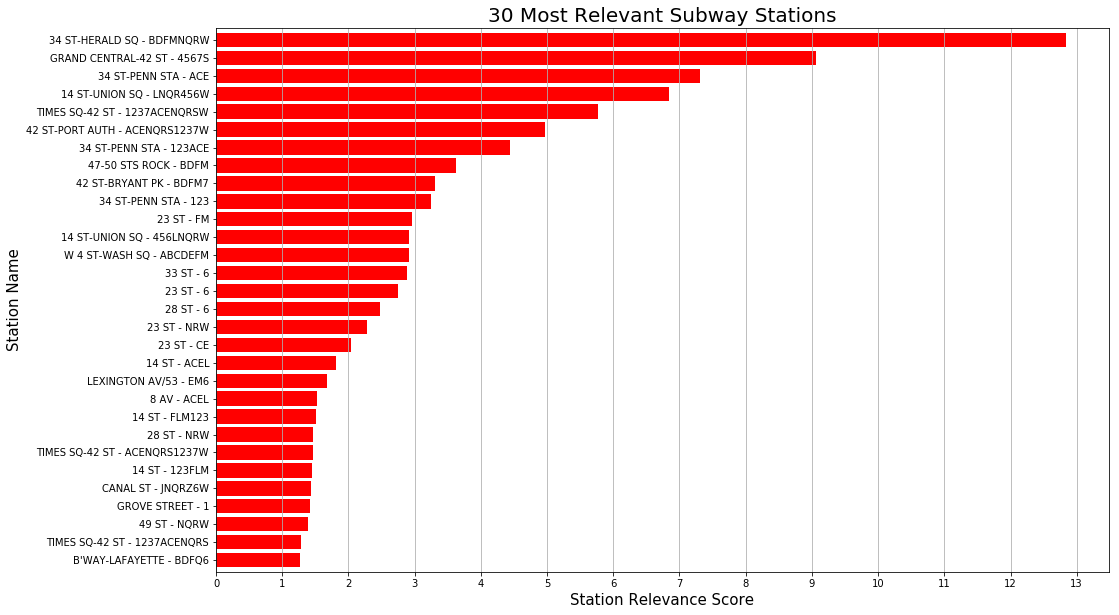

In [94]:
(top_30_important_stations['Relevance']
 .plot(kind='barh', 
       color = 'red', 
       linewidth=10, 
       width=0.8,
       align='center',
       figsize =(16,10)
      )
)
plt.xlabel('Station Relevance Score', fontsize = 15)
plt.ylabel('Station Name', fontsize = 15)
plt.title('30 Most Relevant Subway Stations', fontsize = 20)
plt.xticks([i for i in range(14)])
plt.grid(True, axis='x')
plt.gca().invert_yaxis();

plt.savefig('../img/top30relevant.png', dpi=200, bbox_inches = 'tight')

In [134]:
top_10_important_station = may_traffic_df.sort_values(by="Relevance", ascending=False).head(10)
top_10_important_station

,TOTAL TRAFFIC,ENTRY DIFFS (ABS),EXIT DIFFS (ABS),Latitude,Longitude,Weight,Relevance
UNIQUE_STATION,,,,,,,
34 ST-HERALD SQ - BDFMNQRW,7.236e+06,3.860e+06,3.376e+06,40.750,-73.988,17.75,12.844
GRAND CENTRAL-42 ST - 4567S,8.240e+06,4.317e+06,3.923e+06,40.753,-73.977,11.00,9.064
34 ST-PENN STA - ACE,4.496e+06,2.386e+06,2.110e+06,40.751,-73.990,16.25,7.307
14 ST-UNION SQ - LNQR456W,4.277e+06,2.284e+06,1.993e+06,40.735,-73.991,16.00,6.843
TIMES SQ-42 ST - 1237ACENQRSW,4.050e+06,2.066e+06,1.984e+06,40.755,-73.987,14.25,5.771
42 ST-PORT AUTH - ACENQRS1237W,4.732e+06,2.750e+06,1.982e+06,40.757,-73.990,10.50,4.968
34 ST-PENN STA - 123ACE,2.728e+06,1.628e+06,1.101e+06,40.751,-73.990,16.25,4.434
47-50 STS ROCK - BDFM,3.365e+06,1.672e+06,1.693e+06,40.758,-73.982,10.75,3.617
42 ST-BRYANT PK - BDFM7,2.405e+06,1.242e+06,1.164e+06,40.755,-73.984,13.75,3.307


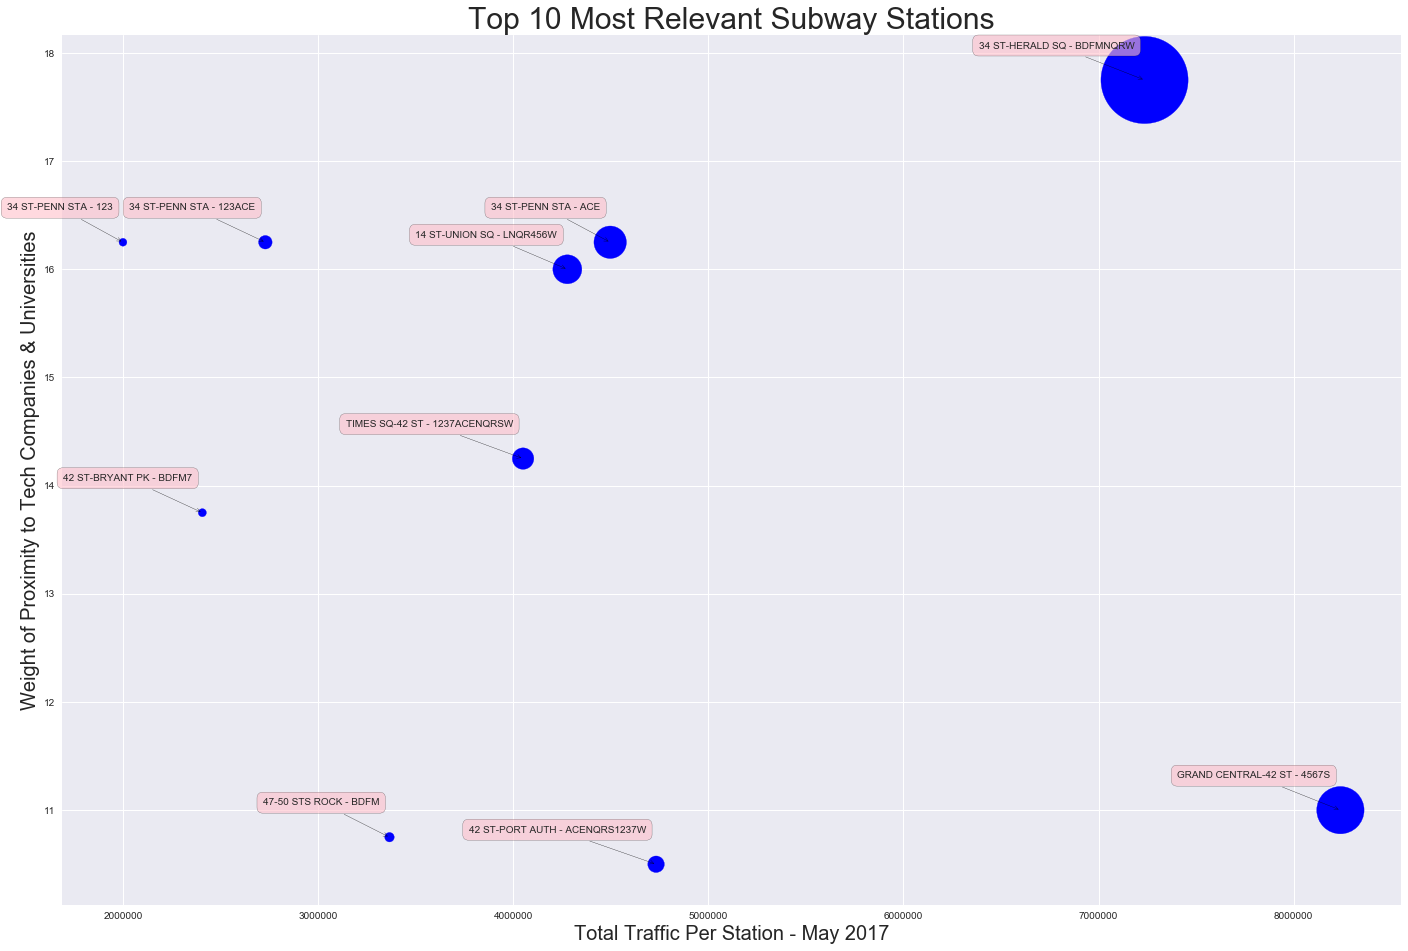

In [135]:
dist1 = top_10_important_station['TOTAL TRAFFIC']
dist2 = top_10_important_station.Weight
n = top_10_important_station.index
labels = [i for i in n]
s = top_10_important_station['Relevance']**3.5

plt.figure(figsize=(24, 16))
plt.scatter(dist1, dist2, s=s, color = 'blue')

for label, x, y in zip(labels, dist1, dist2):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 30),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.6', fc='pink', alpha=0.6),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.xlabel('Total Traffic Per Station - May 2017',fontsize = 20)
plt.ylabel('Weight of Proximity to Tech Companies & Universities', fontsize = 20)
plt.title('Top 10 Most Relevant Subway Stations', fontsize = 30);

# plt.savefig('scatter2.png', dpi=200, bbox_inches = 'tight')